In [1]:
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm import tqdm
import torch
from scipy import stats

sys.path.insert(0, 'src')
from utils.utils import read_lists, load_image, ensure_dir, write_lists
from utils.visualizations import histogram, plot, show_image_rows, bar_graph, pie_chart
from utils.df_utils import convert_string_columns
from utils.metric_utils import top_2_confusion, add_confidence, sort_and_bin_df, calculate_bin_agreement, run_feature_importance_trial, correlated_variables, print_summary, filter_df, string_to_list, plot_metric_v_inputs

# Analyze human, explainer, and model from CIFAR-10 

### Paths for human, explainer, and model

In [2]:
human_probabilities_path = 'data/cifar10-soft-labels/cifar10h-probs.npy'
model_outputs_path = 'saved/cifar10/resnet18/outputs_predictions.pth'
explainer_outputs_path = 'saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/outputs_predictions.pth'
explainer_type = 'pixel'
processed_data_path = 'data/cifar10-processed/cifar10_image_labels.pth'

save_dir = os.path.join(os.path.dirname(explainer_outputs_path), 'analysis')
ensure_dir(save_dir)

## Populate  & Save DF

### Add outputs and ground truth

In [3]:
human_outputs = np.load(human_probabilities_path)
human_predictions = np.argmax(human_outputs, axis=1)
human_out = {
    'outputs': human_outputs,
    'probabilities': human_outputs,
    'predictions': human_predictions
}
model_out = torch.load(model_outputs_path)['test']
explainer_out = torch.load(explainer_outputs_path)['test']
outputs = {
    'human': human_out,
    'explainer': explainer_out,
    'model': model_out
}
ground_truth_labels = torch.load(processed_data_path)['test']['predictions']

In [4]:
df_dict = {}
# Add human, model, explainer outputs/probabilities/predictions
for agent, output in outputs.items():
    for out_type in ['outputs', 'probabilities', 'predictions']:
        df_dict['{}_{}'.format(agent, out_type)] = list(output[out_type])

# Add ground truth
df_dict['ground_truth'] = ground_truth_labels
df = pd.DataFrame(df_dict)
print(df.columns)
assert len(df.columns) == 10

Index(['human_outputs', 'human_probabilities', 'human_predictions',
       'explainer_outputs', 'explainer_probabilities', 'explainer_predictions',
       'model_outputs', 'model_probabilities', 'model_predictions',
       'ground_truth'],
      dtype='object')


### Add entropy, t2c, top_confidence

In [11]:
# Calculate each metric in metric_fns for each agent in agents
metric_fns = [
    ('t2c', top_2_confusion),
    ('entropy', stats.entropy),
    ('top_confidence', add_confidence)]
agents = ['human', 'explainer', 'model']

for agent in agents:
    for metric_name, metric_fn in metric_fns:
        if metric_name == 't2c':
            inputs = np.stack(df['{}_outputs'.format(agent)].to_numpy(), axis=0)
            t2c = metric_fn(inputs)
            df['{}_{}'.format(agent, metric_name)] = t2c
            min_t2c = np.amin(t2c)
            max_t2c = np.amax(t2c)
            scaled_t2c = (t2c - min_t2c) / (max_t2c - min_t2c)
            df['{}_scaled_t2c'.format(agent)] = scaled_t2c
            t2c_ratio = metric_fn(inputs, mode='ratio')
            df['{}_t2c_ratio'.format(agent)] = t2c_ratio
        elif metric_name == 'entropy':
            inputs = np.stack(df['{}_probabilities'.format(agent)].to_numpy(), axis=0)
            metric = metric_fn(inputs, axis=1)
            df['{}_{}'.format(agent, metric_name)] = metric
        elif metric_name == 'top_confidence':
            df = add_confidence(
                df=df,
                agent=agent,
                top=True)
            

### Add alignment

In [12]:
agent_pairs = [
    ('human', 'explainer'),
    ('human', 'model'),
    ('model', 'explainer')]
for agent1, agent2 in agent_pairs:
    agent1_predictions = df['{}_predictions'.format(agent1)]
    agent2_predictions = df['{}_predictions'.format(agent2)]
    alignment = np.where(agent1_predictions == agent2_predictions, 1, 0)
    df['{}_{}_alignment'.format(agent1, agent2)] = alignment
print("Added all three pairs of alignment to the dataframe")

Added all three pairs of alignment to the dataframe


### Add 5-way breakdown

In [13]:
cases = [
    ('case1', lambda h, e, m: (m == e) & (e == h)),  # model = explainer = human
    ('case2', lambda h, e, m: (m == e) & (e != h)),  # model = explainer != human
    ('case3', lambda h, e, m: (m == h) & (e != h)),  # model = human != explainer
    ('case4', lambda h, e, m: (e == h) & (m != h)),  # explainer = human != model
    ('case5', lambda h, e, m: (m != e) & (e != h) & (m != h)),  # model != explainer != human != model
]
running_sum = 0
for name, lambda_fn in cases:
    case_col = list(map(lambda_fn, df['human_predictions'], df['explainer_predictions'], df['model_predictions']))    
    df[name] = case_col
    running_sum += df[name].sum()
    print("{:.3f}% samples in {}".format(100 * df[name].sum() / len(df), name))
assert running_sum == len(df)

39.700% samples in case1
1.660% samples in case2
53.210% samples in case3
1.370% samples in case4
4.060% samples in case5


#### Add image index

In [18]:
image_idxs = df.index.values
df['image_idxs'] = image_idxs

[   0    1    2 ... 9997 9998 9999]


In [19]:
print(df.columns)

Index(['human_outputs', 'human_probabilities', 'human_predictions',
       'explainer_outputs', 'explainer_probabilities', 'explainer_predictions',
       'model_outputs', 'model_probabilities', 'model_predictions',
       'ground_truth', 'human_t2c', 'human_t2c_ratio', 'human_entropy',
       'human_top_confidence', 'explainer_t2c', 'explainer_t2c_ratio',
       'explainer_entropy', 'explainer_top_confidence', 'model_t2c',
       'model_t2c_ratio', 'model_entropy', 'model_top_confidence',
       'human_explainer_alignment', 'human_model_alignment',
       'model_explainer_alignment', 'case1', 'case2', 'case3', 'case4',
       'case5', 'human_scaled_t2c', 'explainer_scaled_t2c', 'model_scaled_t2c',
       'image_idxs'],
      dtype='object')


### Save DF 

In [20]:

csv_save_path = os.path.join(save_dir, '{}_explainer.csv'.format(explainer_type))
if os.path.exists(csv_save_path):
    print("Path {} already exists".format(csv_save_path))
else:
    df.to_csv(csv_save_path)
    print("Saved CSV to {}".format(csv_save_path))

Saved CSV to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/pixel_explainer.csv


## Load DF

In [26]:
graph_save_dir = os.path.join(save_dir, 'graphs')
ensure_dir(graph_save_dir)

csv_save_path = 'saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/pixel_explainer.csv'
if os.path.exists(csv_save_path):
    df = pd.read_csv(csv_save_path)
    print("Loaded CSV from {}".format(csv_save_path))
else:
    print("Path {} does not exists".format(csv_save_path))

Loaded CSV from saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/pixel_explainer.csv


## Some basic stats

human-explainer alignment: 41.070% (4107/10000)
human-model alignment: 92.910% (9291/10000)
model-explainer alignment: 41.360% (4136/10000)
Case 1: model = explainer = human: 39.700% (3970/10000)
Case 2: model = explainer != human: 1.660% (166/10000)
Case 3: model = human != explainer: 53.210% (5321/10000)
Case 4: explainer = human != model: 1.370% (137/10000)
Case 5: explainer != human; human != model; model != explainer: 4.060% (406/10000)


<Figure size 432x288 with 0 Axes>

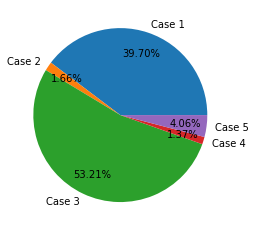

(<Figure size 432x288 with 1 Axes>, <Axes: >)

In [27]:
# Print % samples aligned
agent_pairs = [
    ('human', 'explainer'),
    ('human', 'model'),
    ('model', 'explainer')]
n_samples = len(df)

for agent1, agent2 in agent_pairs:
    n_aligned = len(df[df['{}_{}_alignment'.format(agent1, agent2)] == 1])
    print("{}-{} alignment: {:.3f}% ({}/{})".format(agent1, agent2, 100 * n_aligned / n_samples, n_aligned, n_samples))
    

# 5 way break down
total_n_aligned = []
# Case 1: model = explainer = human
n_aligned = len(df[(df['human_explainer_alignment'] == 1) & (df['human_model_alignment'] == 1) & (df['model_explainer_alignment'] == 1)])
print("Case 1: model = explainer = human: {:.3f}% ({}/{})".format(100 * n_aligned / n_samples, n_aligned, n_samples))
total_n_aligned.append(n_aligned)

# Case 2: model = explainer != human
n_aligned = len(df[(df['model_explainer_alignment'] == 1) & (df['human_explainer_alignment'] != 1)])
print("Case 2: model = explainer != human: {:.3f}% ({}/{})".format(100 * n_aligned / n_samples, n_aligned, n_samples))
total_n_aligned.append(n_aligned)

# Case 3: model = human != explainer
n_aligned = len(df[(df['human_model_alignment'] == 1) & (df['model_explainer_alignment'] != 1)])
print("Case 3: model = human != explainer: {:.3f}% ({}/{})".format(100 * n_aligned / n_samples, n_aligned, n_samples))
total_n_aligned.append(n_aligned)

# Case 4: explainer = human != model
n_aligned = len(df[(df['human_explainer_alignment'] == 1) & (df['model_explainer_alignment'] != 1)])
print("Case 4: explainer = human != model: {:.3f}% ({}/{})".format(100 * n_aligned / n_samples, n_aligned, n_samples))
total_n_aligned.append(n_aligned)

# Case 5: explainer != human; human != model; model != explainer
n_aligned = len(df[(df['human_explainer_alignment'] != 1) & (df['model_explainer_alignment'] != 1) & (df['human_model_alignment'] != 1)])
print("Case 5: explainer != human; human != model; model != explainer: {:.3f}% ({}/{})".format(100 * n_aligned / n_samples, n_aligned, n_samples))
total_n_aligned.append(n_aligned)
total_n_aligned = np.array(total_n_aligned)

assert np.sum(total_n_aligned) == n_samples

pie_chart(
    sizes=total_n_aligned,
    labels=["Case 1", "Case 2", "Case 3", "Case 4", "Case 5"])

## RQ: For each alignment pair, which confusion metric best predicts it?


### Conduct sensitivity of n_bins on Pearson's between confusion and alignment

<Figure size 432x288 with 0 Axes>

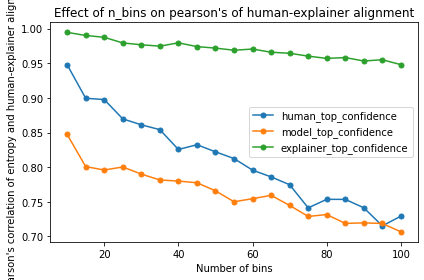

<Figure size 432x288 with 0 Axes>

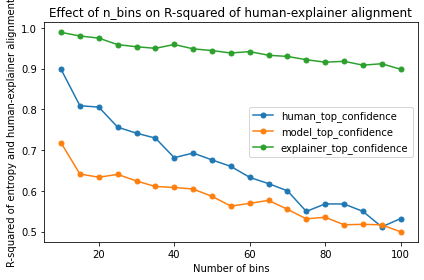

<Figure size 432x288 with 0 Axes>

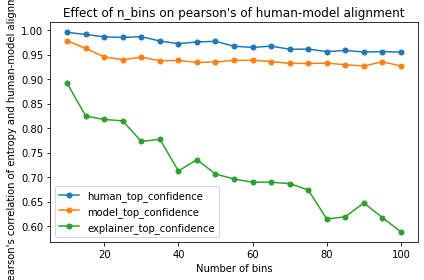

<Figure size 432x288 with 0 Axes>

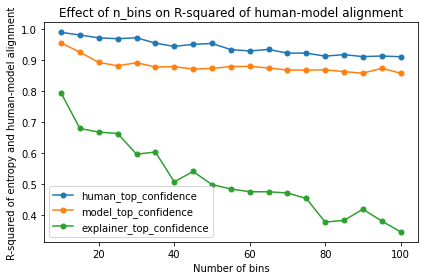

<Figure size 432x288 with 0 Axes>

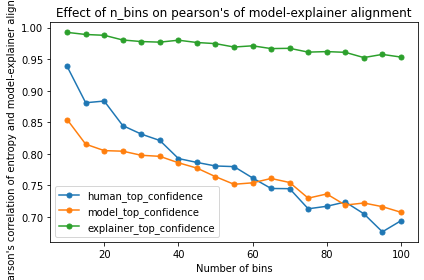

<Figure size 432x288 with 0 Axes>

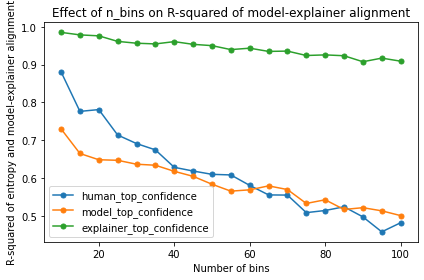

In [30]:
nbins_sensitivity_save_dir = os.path.join(graph_save_dir, 'nbins_sensitivity')
ensure_dir(nbins_sensitivity_save_dir)

agent_pairs = [
        ('human', 'explainer'),
        ('human', 'model'),
        ('model', 'explainer')]
agents = ['human', 'model', 'explainer']
n_bins = [i for i in range(10, 101, 5)]
# iv_name_templates = ['{}_entropy', '{}_t2c']
# iv_name_templates = ['{}_t2c', '{}_entropy']
iv_name_templates = ['{}_top_confidence', '{}_t2c', '{}_entropy']

for pair_idx, pair in enumerate(agent_pairs):
    agent1, agent2 = pair
    all_pearsons = []
    all_r_squared = []

    for iv_agent in agents:
        iv_names = [template.format(iv_agent) for template in iv_name_templates]
        
        cur_pearsons = []
        cur_r_squared = []
        for n_bin in n_bins:
            bin_rows, iv_means, iv_stds, iv_ses = sort_and_bin_df(
                df=df,
                sort_columns=iv_names, 
                n_bins=n_bin)
            cur_agreements, agreement_stds, agreement_ses = calculate_bin_agreement(
                bin_rows=bin_rows,
                agent1=agent1,
                agent2=agent2)
            pearsons = stats.pearsonr(iv_means, cur_agreements).statistic
            cur_pearsons.append(pearsons)

            r_squared = pearsons ** 2
            cur_r_squared.append(r_squared)
        all_pearsons.append(cur_pearsons)
        all_r_squared.append(cur_r_squared)

    # Plot pearsons v n_bins
    plot(
        xs=[n_bins for i in range(3)],
        ys=all_pearsons,
        labels=[iv_name_templates[0].format(agent) for agent in agents],
        xlabel='Number of bins',
        ylabel="Pearson's correlation of entropy and {}-{} alignment".format(agent1, agent2),
        title='Effect of n_bins on pearson\'s of {}-{} alignment'.format(
            agent1, agent2),
        show=True,
        save_path=os.path.join(graph_save_dir, 'nbins_pearsons_{}-{}_{}.png'.format(
            agent1, agent2, iv_name_templates[0].split("_")[1])))


    # Plot r-squared v n_bins
    plot(
        xs=[n_bins for i in range(3)],
        ys=all_r_squared,
        labels=[iv_name_templates[0].format(agent) for agent in agents],
        xlabel='Number of bins',
        ylabel="R-squared of entropy and {}-{} alignment".format(agent1, agent2),
        title='Effect of n_bins on R-squared of {}-{} alignment'.format(agent1, agent2),
        show=True,
        save_path=os.path.join(nbins_sensitivity_save_dir, 'nbins_rsquared_{}-{}_{}.png'.format(
            agent1, agent2, iv_name_templates[0].split("_")[1])))

### Linear Regression between confusion metrics and alignment

Figure saved to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/graphs/iv_confusion_dv_alignment/human-explainer_alignment_v_entropy.png


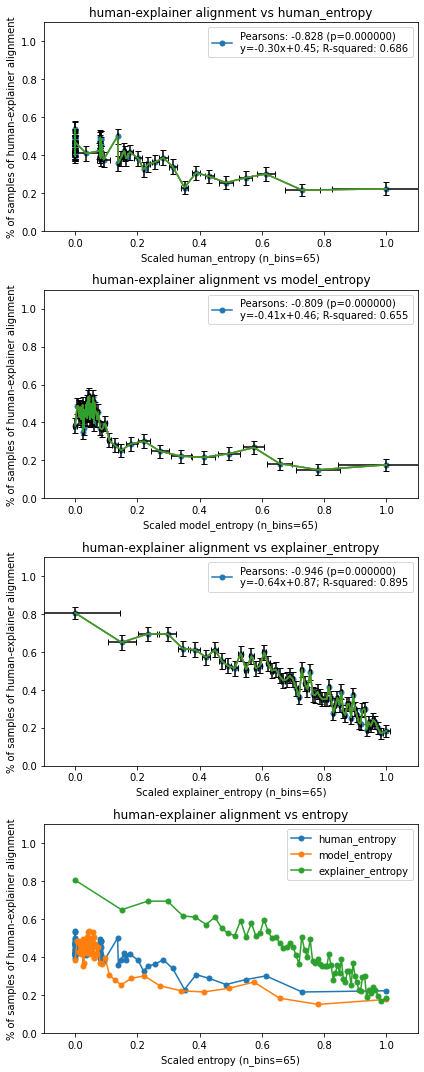

Figure saved to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/graphs/iv_confusion_dv_alignment/human-model_alignment_v_entropy.png


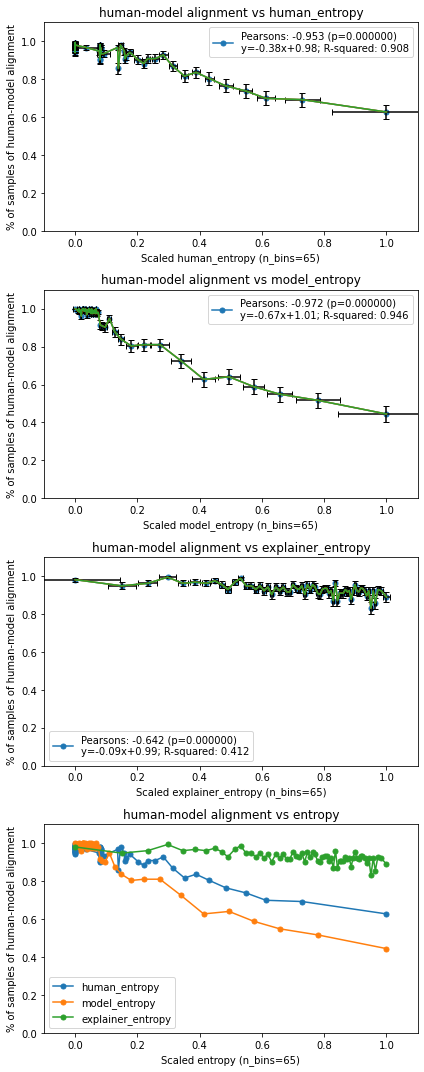

Figure saved to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/graphs/iv_confusion_dv_alignment/model-explainer_alignment_v_entropy.png


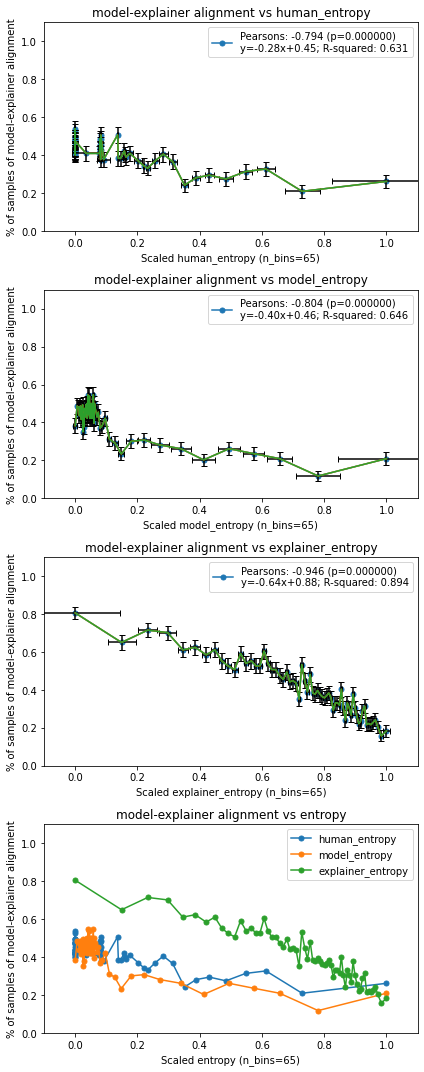

Pearsons between variance of confusion and variance of alignment: 0.042 (p=0.308134)
y=0.02x+0.03; R-squared: 0.002


In [34]:
linear_reg_save_dir = os.path.join(graph_save_dir, 'iv_confusion_dv_alignment')
ensure_dir(linear_reg_save_dir)

agent_pairs = [
    ('human', 'explainer'),
    ('human', 'model'),
    ('model', 'explainer')]
agents = ['human', 'model', 'explainer']

plot_xerr = True
plot_yerr = True

confusion_templates = ['{}_entropy', '{}_t2c']
# confusion_templates = ['{}_t2c', '{}_entropy']
# confusion_templates = ['{}_top_confidence', '{}_t2c', '{}_entropy']
x_variance = []
y_variance = []
if 'sift' in explainer_type:
    if 'entropy' in confusion_templates[0]:
        n_bins = 15
    elif 't2c' in confusion_templates[0]:
        n_bins = 20
    elif 'top_confidence' in confusion_templates[0]:
        n_bins = 25
    else:
        raise ValueError("Confusion type in '{}' not supported.".format(confusion_templates[0]))
if 'pixel' in explainer_type:
    if 'entropy' in confusion_templates[0]:
        n_bins = 65
    elif 't2c' in confusion_templates[0]:
        n_bins = 40
    elif 'top_confidence' in confusion_templates[0]:
        n_bins = 55
    else:
        raise ValueError("Confusion type in '{}' not supported.".format(confusion_templates[0]))
else:
    raise ValueError("Explainer type '{}' not supported.".format(explainer_type))
for agent_pair in agent_pairs:
    agent1, agent2 = agent_pair
    confusions = []
    agreements = []
    fig, axs = plt.subplots(4, 1, figsize=(6, 15))
    
    ylabel = '% of samples of {}-{} alignment'.format(agent1, agent2)
    # Separate plot for confusion from each agent
    for idx, agent in enumerate(agents):
        confusion_names = [confusion_template.format(agent) for confusion_template in confusion_templates]
        xlabel = 'Scaled {} (n_bins={})'.format(confusion_names[0], n_bins)
        bin_rows, iv_means, iv_stds, iv_ses = sort_and_bin_df(
            df=df,
            sort_columns=confusion_names, 
            n_bins=n_bins)
        min_iv = np.amin(iv_means)
        max_iv = np.amax(iv_means)
        iv_means = (iv_means - min_iv) / (max_iv - min_iv)
        
        cur_agreement, agreement_stds, agreement_ses = calculate_bin_agreement(
                bin_rows=bin_rows,
                agent1=agent1,
                agent2=agent2)
        confusions.append(iv_means)
        agreements.append(cur_agreement)
        
        pearsons = stats.pearsonr(
            x=iv_means,
            y=cur_agreement)
        slope, yint, r, p, std_err = stats.linregress(iv_means, cur_agreement)
        r_squared = r ** 2
        fig, ax = plot(
            xs=[iv_means],
            ys=[cur_agreement],
            fig=fig,
            ax=axs[idx],
            xlabel=xlabel,
            ylabel=ylabel,
            ylimits=[0, 1.1],
            xlimits=[-0.1, 1.1],
            labels=['Pearsons: {:.3f} (p={:.6f})\ny={:.2f}x+{:.2f}; R-squared: {:.3f}'.format(
                pearsons.statistic, pearsons.pvalue, slope, yint, r_squared)],
            title='{}-{} alignment vs {}'.format(agent1, agent2, confusion_names[0]),
            show=False)
        
        if plot_xerr:
            ax.errorbar(
                x=iv_means,
                y=cur_agreement,
                xerr=iv_stds,
                ecolor='black',
                capsize=3.0)
        if plot_yerr:
            ax.errorbar(
                x=iv_means,
                y=cur_agreement,
                yerr=agreement_ses,
                ecolor='black',
                capsize=3.0)
        x_variance.append(iv_stds)
        y_variance.append(agreement_ses)
        axs[idx] = ax
    
    xlabel = 'Scaled {} (n_bins={})'.format(confusion_templates[0].split('_')[1], n_bins)
    title = '{}-{} alignment vs entropy'.format(agent1, agent2)
    fig, ax = plot(
        xs=confusions,
        ys=agreements,
        fig=fig,
        ax=axs[-1],
        labels=[confusion_templates[0].format(agent) for agent in agents],
        xlabel=xlabel,
        ylabel=ylabel,
        ylimits=[0, 1.1],
        xlimits=[-0.1, 1.1],
        title=title,
        show=False)
    axs[-1] = ax
    save_path = os.path.join(linear_reg_save_dir, '{}-{}_alignment_v_{}.png'.format(agent1, agent2, confusion_templates[0].split('_')[1]))
    plt.savefig(save_path)
    print("Figure saved to {}".format(save_path))
    plt.show()
    
x_variance = np.concatenate(x_variance, axis=0)
y_variance = np.concatenate(y_variance, axis=0)

slope, yint, r, p, std_err = stats.linregress(
    x=x_variance,
    y=y_variance)
print('Pearsons between variance of confusion and variance of alignment: {:.3f} (p={:.6f})\ny={:.2f}x+{:.2f}; R-squared: {:.3f}'.format(
        r, p, slope, yint, r**2))


### Logistic Regression Trials

In [44]:
# Set constants
seed = 0
penalty = 'l2'
solver = 'liblinear'
class_weight = 'balanced'
logistic_regression_args = {
    'penalty': penalty,
    'solver': solver,
    'class_weight': class_weight
}

metric_names = ['accuracy', 'precision', 'recall', 'f1', 'neg_log_loss']

# Split dataframe into train/test
train_split = 0.7
train_rows = df.sample(frac=train_split, random_state=seed)
val_rows = df.drop(train_rows.index)
assert len(set(train_rows.index).intersection(set(val_rows.index))) == 0

# Create x, y data
iv_types = ['top_confidence', 'entropy', 't2c']
agents = ['human', 'model', 'explainer']
agent_pairs = [
    ('human', 'explainer'),
    ('model', 'explainer'),
    ('human', 'model')]

# x_names = ['{}_{}'.format(agent, confusion_type) for agent in agents]
agents_list = [
    ['human'],
    ['model'],
    ['explainer'],
    ['human', 'explainer'],
    ['human', 'model'],
    ['model', 'explainer'],
    ['human', 'explainer', 'model']
]

### Run logreg trials

In [45]:
# List to store results from all trials
trials = []
trial_keys = []
trial_idx = 1
n_trials = len(iv_types) * len(agents_list) * len(agent_pairs)
for iv_type in iv_types:
    for idx, agents in enumerate(agents_list):
        x_names = ['{}_{}'.format(agent, iv_type) for agent in agents]
        for x_name in x_names:
            assert x_name in df.columns 
        
        for agent1, agent2 in agent_pairs:
            # set seed 
            seed = 0
            y_names = ['{}_{}_alignment'.format(agent1, agent2)]
            print("Itr {}/{}: IV: {} DV: {}".format(trial_idx, n_trials, x_names, y_names))
            cur_data, trial_key = run_feature_importance_trial(
                train_rows=train_rows,
                val_rows=val_rows,
                x_names=x_names,
                y_names=y_names,
                metric_names=metric_names,
                trial_id=trial_idx-1,
                logistic_regression_args=logistic_regression_args,
                seed=seed)

            trials.append(cur_data)
            trial_keys.append(trial_key)
            trial_idx += 1


Itr 1/63: IV: ['human_top_confidence'] DV: ['human_explainer_alignment']
Best accuracy: 0.427 Regularization: 0.001
Best accuracy: 0.461 Regularization: 0.005
Best accuracy: 0.4713333333333333 Regularization: 0.01
Best accuracy: 0.495 Regularization: 0.05
Learned classifier to predict ['human_explainer_alignment'] from ['human_top_confidence']
Coefficients: [[0.81486993]]
Itr 2/63: IV: ['human_top_confidence'] DV: ['model_explainer_alignment']
Best accuracy: 0.426 Regularization: 0.001
Best accuracy: 0.45666666666666667 Regularization: 0.005
Best accuracy: 0.467 Regularization: 0.01
Best accuracy: 0.49066666666666664 Regularization: 0.05
Learned classifier to predict ['model_explainer_alignment'] from ['human_top_confidence']
Coefficients: [[0.73337164]]
Itr 3/63: IV: ['human_top_confidence'] DV: ['human_model_alignment']
Best accuracy: 0.9283333333333333 Regularization: 0.001
Learned classifier to predict ['human_model_alignment'] from ['human_top_confidence']
Coefficients: [[0.156761

In [46]:
logreg_save_dir = os.path.join(save_dir, 'logreg_results')
ensure_dir(logreg_save_dir)

# Save feature importance results in different forms
logreg_df = pd.DataFrame(trials)
logreg_df_path = os.path.join(logreg_save_dir, 'sensitivity.csv')
logreg_df.to_csv(logreg_df_path)
print("Saved csv to {}".format(logreg_df_path))
logreg_pth_path = os.path.join(logreg_save_dir, 'sensitivity.pth')
torch.save(trials, logreg_pth_path)
print("Saved list to {}".format(logreg_pth_path))
json_save_path = os.path.join(logreg_save_dir, 'sensitivity.json')
with open(json_save_path, 'w') as f:
    json.dump(trials, f)
print("Saved list to {}".format(json_save_path))

# Write map of trial idx to iv/dv combination
trial_keys_path = os.path.join(logreg_save_dir, 'trial_keys.txt')
write_lists(trial_keys, trial_keys_path)

Saved csv to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/logreg_results/sensitivity.csv
Saved list to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/logreg_results/sensitivity.pth
Saved list to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/logreg_results/sensitivity.json


### Analyze logreg results

In [51]:
logreg_df_path = 'saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/logreg_results/sensitivity.csv'
logreg_df = pd.read_csv(logreg_df_path)

all_x_names = [
    'human_top_confidence', 'model_top_confidence', 'explainer_top_confidence', 
    'human_entropy', 'model_entropy', 'explainer_entropy', 
    'human_t2c', 'model_t2c', 'explainer_t2c'
]

# Obtain correlation pairs
low_corr_set, med_corr_set, high_corr_set = correlated_variables(
    train_rows=train_rows,
    x_names=all_x_names)

Low correlation pairs (<0.3)
('human_top_confidence', 'model_top_confidence', 0.2191106900452505, 7.465852913303957e-77)
('human_top_confidence', 'explainer_top_confidence', 0.12572348236380224, 4.624312412168348e-26)
('human_top_confidence', 'model_entropy', -0.21732177809317632, 1.3254026717693604e-75)
('human_top_confidence', 'explainer_entropy', -0.11551617409604048, 3.1502281567506123e-22)
('human_top_confidence', 'model_t2c', -0.23066374546819363, 3.4176295351200043e-85)
('human_top_confidence', 'explainer_t2c', -0.08975944117510234, 5.326271934748853e-14)
('model_top_confidence', 'explainer_top_confidence', 0.107282964052057, 2.250624436491783e-19)
('model_top_confidence', 'human_entropy', -0.21796619440733558, 4.71647239496976e-76)
('model_top_confidence', 'explainer_entropy', -0.11315549246909044, 2.1792140424816995e-21)
('model_top_confidence', 'human_t2c', -0.21949469837215524, 4.012818405529661e-77)
('model_top_confidence', 'explainer_t2c', -0.05648903016068513, 2.254689176

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(human_t2c, explainer_t2c) has low correlation
(human_t2c, model_t2c) has low correlation
(model_t2c, explainer_t2c) has low correlation
Highest accuracy with ['model_t2c', 'explainer_t2c']: 0.6583


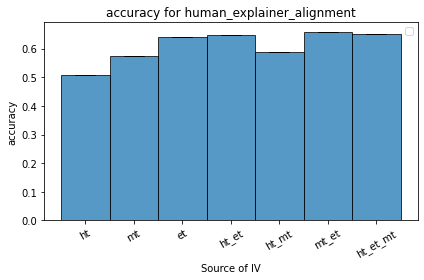

Row index 42
IV: ['human_t2c'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.5083
		 'human_t2c' sensitivity: 0.0477
	f1: 0.5048
		 'human_t2c' sensitivity: 0.0439
Row index 45
IV: ['model_t2c'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.5740
		 'model_t2c' sensitivity: 0.0320
	f1: 0.5335
		 'model_t2c' sensitivity: 0.0457
Row index 48
IV: ['explainer_t2c'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.6420
		 'explainer_t2c' sensitivity: 0.1166
	f1: 0.6192
		 'explainer_t2c' sensitivity: 0.1558
Row index 51
IV: ['human_t2c', 'explainer_t2c'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.6483
		 'human_t2c' sensitivity: 0.0163
		 'explainer_t2c' sensitivity: 0.1095
	f1: 0.6146
		 'human_t2c' sensitivity: 0.0279
		 'explainer_t2c' sensitivity: 0.1623
Row index 54
IV: ['human_t2c', 'model_t2c'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.5863
		 'human_t2c' sensitivity: 0.0062
		 'model_t2c' sensitivity: 0.0211
	f1: 0.5572
		 'human_

In [68]:
ivs = ['t2c']
dv = 'human_explainer_alignment'
metrics=['accuracy', 'f1']

drop_correlated = True

cur_df = filter_df(logreg_df,
    ivs=ivs,
    dv=dv)

# Drop rows that have correlated variables
if drop_correlated:
    drop_idxs = []
    for idx, row in cur_df.iterrows():
        row_ivs = string_to_list(row['iv'], dtype='string')
        row_ivs = [word.replace("'", "") for word in row_ivs]
        
        # if len(row_ivs) > 2:
        #     drop_idxs.append(row['Unnamed: 0'])
        if len(row_ivs) == 2:
            var1, var2 = row_ivs
            if (var1, var2) in low_corr_set or (var2, var1) in low_corr_set:
                print("({}, {}) has low correlation".format(var1, var2))
            elif (var1, var2) in med_corr_set or (var2, var1) in med_corr_set:
                print("({}, {}) has moderate correlation".format(var1, var2))
            else:
                drop_idxs.append(row['Unnamed: 0'])
                print("Dropping ({}, {})".format(var1, var2))
    cur_df = cur_df.drop(drop_idxs, axis=0)

log_path = 'temp/temp.txt'
highest_acc_row = cur_df.loc[cur_df['accuracy'].idxmax()]
print("Highest accuracy with {}: {:.4f}".format(
    highest_acc_row['iv'],
    highest_acc_row['accuracy']))

plot_metric_v_inputs(
    df=cur_df,
    ivs=ivs,
    dv=dv,
    graph_metric='accuracy')
print_summary(
    df=cur_df,
    metrics=metrics,
    log_path=log_path)